In [1]:
from scipy.stats import multivariate_normal as mult_gauss
import numpy as np
import random
from numpy import linalg as LA
import sklearn as sklearn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pylab import *
from sklearn.cluster import KMeans
# %matplotlib qt

## The Expectation Maximization algorithm for a Gaussian mixture model is implemented as follows:

In [2]:
class EM_Gaussian_Misture(object):
    
    def __init__(self, X_data, K, tol):
        self.X_Data = X_data                       # X_data has dimension in the rows and observations in the coloumns
        self.K = K                                 # Mixture size
        self.d, self.N = self.X_Data.shape              # find the shape of the data
        self.gam = np.zeros((self.N,self.K))            # initialize all gammas as zero
        
        kmeans = KMeans(n_clusters=self.K, random_state=1).fit(self.X_Data.T)
        lables = kmeans.labels_
        unique, counts = np.unique(lables, return_counts=True)
        
#         self.pi = np.random.uniform(0,1,self.K)         # initialize the contributions
#         self.mu = np.random.random((self.d,self.K))     # initialize the means

        self.pi = np.array(counts)/self.N                 # initialize the contributions
        self.mu = np.array(kmeans.cluster_centers_).T     # initialize the means
        self.sigma =  np.array([np.eye(self.d)]*self.K) # initialize the covariances
        self.tol = tol
        

#     def E_step(self):  # compute the posteriori probabilities
#         for i in range(self.N):
#             for j in range(self.K):
#                 self.gam[i,j] = self.pi[j]*mult_gauss(self.mu[:,j], self.sigma[j,:,:]).pdf(self.X_Data[:,i]) # first find the numerator for all n's in N and k's in K
#         sumd = self.gam.sum(1)     # to find the denominatior sum over all k's for a n in N
#         self.gam = self.gam.T/sumd # find the posterior probabilities  
#         return self.gam.T 

    def E_step(self):  # compute the posteriori probabilities
        
        
        self.gam = [(self.pi[j]*mult_gauss.pdf(self.X_Data.T, self.mu[:,j], self.sigma[j,:,:]))
            for j in range(K)]
        self.gam = np.array(self.gam)
        
        sumd = self.gam.sum(0)     # to find the denominatior sum over all k's for a n in N
        self.gam = self.gam/sumd   # find the posterior probabilities  
        
        return self.gam.T 
    
#     def M_step(self):
#         self.gam = self.E_step()  # get the gammas 
#         N_k = self.gam.sum(0)    # compute Nk by summing all the rows of gamma
        
#         self.pi = N_k/self.N     # compute pi
        
#         self.mu = np.dot(self.gam.T, self.X_Data.T)
#         self.mu = self.mu.T/N_k  # compute mu       
        
#         for i in range(self.K):                    # compute sigma
#             for j in range(self.N):
#                 dum = np.reshape((self.X_Data[:,j] -  self.mu[:,i]), (self.d,1)) # compute (X_n-mu_n)
#                 self.sigma[i,:,:] += self.gam[j,i]*np.dot(dum, dum.T)           # compute (X_n-mu_n)(X_n-mu_n)^T
#             self.sigma[i,:,:] = self.sigma[i,:,:]/N_k[i]  # divide sigma of each mixture by N_k to compute sigma
        
#         return self.pi, self.gam, self.mu, self.sigma

    def M_step(self):
        self.gam = self.E_step()  # get the gammas 
        N_k = self.gam.sum(0)    # compute Nk by summing all the rows of gamma
        
        self.pi = N_k/self.N     # compute pi
        
        self.mu = np.dot(self.gam.T, self.X_Data.T)
        self.mu = self.mu.T/N_k  # compute mu       
        
        for j in range(self.K):                    # compute sigma
            dum = self.X_Data - np.reshape(self.mu[:,j], (self.d,1))
            dum = dum.T
            self.sigma[j,:,:] = ((np.reshape(self.gam[:,j],(self.N,1,1))*(reshape(dum,(self.N,self.d,1))*reshape(dum,(self.N,1,self.d)))).sum(0))/N_k[j]
      
        
        return self.pi, self.gam, self.mu, self.sigma
    
#     def EM_Gauss(self):  # to compute log-likelihood and check convergence
#         error = 10
#         l_old = 0
#         iter = 0
#         while error>self.tol:
            
#             self.pi, self.gam, self.mu, self.sigma = self.M_step()

#             l_new = 0.0
#             for i in range(self.N):
#                 dum = 0.0
#                 for j in range(self.K):
#                     dum += self.pi[j]*mult_gauss(self.mu[:,j], self.sigma[j,:,:]).pdf(self.X_Data[:,i])
#                 dum = np.log(dum)
#                 l_new += dum

#             error = abs(l_new-l_old)
#             l_old = l_new        
#             print('iter =', iter, ', error = ', error)
#             iter += 1
#         return np.array(self.pi), np.array(self.mu), np.array(self.sigma)

    def EM_Gauss(self):  # to compute log-likelihood and check convergence
        error = 10
        l_old = 0
        iter = 0
        while error>self.tol:
                        
            self.pi, self.gam, self.mu, self.sigma = self.M_step()
            l_new = 0

#         for i in range(N):
#             dum = 0.0
#             for j in range(K):
#                 dum += pi[j]*mult_gauss(mu[:,j], sigma[j,:,:]).pdf(X_Data[:,i])
#             dum = np.log(dum)
#             l_new += dum
            
            dum = [(self.pi[j]*mult_gauss.pdf(self.X_Data.T, self.mu[:,j], self.sigma[j,:,:]))
               for j in range(K)]
            dum = np.array(dum)
            l_new = np.log(dum.sum(0)).sum()
            
            

            error = abs(l_new-l_old)
            l_old = l_new        
            print('iter =', iter, ', error = ', error)
            iter += 1
        return np.array(self.pi), np.array(self.mu), np.array(self.sigma)

## Generate data

In [3]:
# def generate_data(mean, cov, pii, N):
def generate_data(generators, N, pi):
#     X_data = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*N))
#                     for pi, mu, sigma in zip(pii, mean, cov)])
    draw = np.random.choice([0, 1, 2], N, p=pi.tolist())
    unique, counts = np.unique(draw, return_counts=True)
    
    mixture_info = (dict(zip(unique, counts)))
    
    X_Data = [np.array(generators[i].rvs()) for i in draw]
    X_Data = np.array(X_Data)
    return X_Data.T, mixture_info

def ploting(X_Data):

    if X_Data.shape[1] == 2:
        fig, ax = plt.subplots(num=1, clear=True)
        handle = ax.plot(X_Data[:,0], X_Data[:,1], '.')
        plt.axis('equal')
#         plt.show()
        
    elif X_Data.shape[1] == 3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot3D(X_Data[:,0], X_Data[:,1], X_Data[:,2], '.')
        
    else:
        print("Can't plot dimension > 3 !!!")

    return None

## Estimate the parametrs

In [4]:
## ------ 2D data generation ------------ ##
pi = np.array([0.4, 0.3, 0.3])
generators = [
    mult_gauss([-10, 10], [[5, 0], [0, 7]]),             
    mult_gauss([2, -5], [[10, 0], [0, 3]]), 
    mult_gauss([1, 1], [[5, 0], [0, 15]])]

## ------ 3D data generation ------------ ##
# mean = np.array([[20,10,1], [-22,15,10], [-30, 10,1]])
# cov = np.array([[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[2,0,0],[0,2,0], [0,0,2]], [[3,0,0],[0,3,0],[0,0,3]] ])
# pi = np.array([0.3, 0.2, 0.1])




N = 10000
K = 3
tol = 0.000001
Data, mixture_info =  generate_data(generators, N, pi)
# X_data = input("Input X_data:")
# print(Data.shape)

X_Data = Data

obj = EM_Gaussian_Misture(X_Data, K, tol)
pi_hat, mu_hat, sigma_hat = obj.EM_Gauss()

print('\n ----------------- The converged parametrs are ----------------- \n')
print('pi_hat = \n', pi_hat, '\n')
print('mu_hat = \n', mu_hat, '\n')
print('Sigma_hat = \n', sigma_hat, '\n')

iter = 0 , error =  56089.25933457786
iter = 1 , error =  45.093996652743954
iter = 2 , error =  12.389119848819973
iter = 3 , error =  7.468416593488655
iter = 4 , error =  5.803131741107791
iter = 5 , error =  4.807149165972078
iter = 6 , error =  4.048944296358968
iter = 7 , error =  3.431164594949223
iter = 8 , error =  2.919552193809068
iter = 9 , error =  2.4940694858378265
iter = 10 , error =  2.139405702604563
iter = 11 , error =  1.8430037362631992
iter = 12 , error =  1.5944896603032248
iter = 13 , error =  1.3853369342104997
iter = 14 , error =  1.2085734680586029
iter = 15 , error =  1.0585163170399028
iter = 16 , error =  0.9305397977950634
iter = 17 , error =  0.8208792030782206
iter = 18 , error =  0.7264680895605125
iter = 19 , error =  0.6448050986946328
iter = 20 , error =  0.5738457675179234
iter = 21 , error =  0.5119150239406736
iter = 22 , error =  0.4576365862376406
iter = 23 , error =  0.40987607472925447
iter = 24 , error =  0.36769519723020494
iter = 25 , erro

## Validate, visualize, and compare with original data:


In [24]:
generators_hat = [
    mult_gauss(mu_hat[:,0], sigma_hat[0,:,:]),             
    mult_gauss(mu_hat[:,1], sigma_hat[1,:,:]), 
    mult_gauss(mu_hat[:,2], sigma_hat[2,:,:])]

X_Data_hat, mixture_info_hat =  generate_data(generators_hat, N, pi_hat)

### 1. Check if the Covarinaces are symmetric and positive definite:

In [25]:
print(sigma_hat.shape)
for i in range(sigma_hat.shape[0]):
    ev, evec = LA.eig(sigma_hat[i,:,:])
    print('Sigma_hat_' + str(i),'= \n',sigma_hat[i,:,:],' \n Eignevalues of Sigma_hat_'+str(i),'=',ev, '\n')

(3, 2, 2)
Sigma_hat_0 = 
 [[4.84279756 0.08474797]
 [0.08474797 6.88462803]]  
 Eignevalues of Sigma_hat_0 = [4.83928606 6.88813953] 

Sigma_hat_1 = 
 [[9.87081669 0.01220974]
 [0.01220974 2.94623064]]  
 Eignevalues of Sigma_hat_1 = [9.87083822 2.94620911] 

Sigma_hat_2 = 
 [[ 4.99821809 -0.29661331]
 [-0.29661331 14.36813063]]  
 Eignevalues of Sigma_hat_2 = [ 4.98883791 14.37751081] 



### 2. Check if the mixture size of the original data and the data generated by the estimated parameters are close:

In [7]:
print('mixture info of the original data: \n', 'pi=', pi,'\n','mixture_info = ', mixture_info, '\n')
print('mixture info of the estimated data: \n', 'pi_hat=', pi_hat,'\n','mixture_info = ', mixture_info_hat, '\n')


mixture info of the original data: 
 pi= [0.4 0.3 0.3] 
 mixture_info =  {0: 3895, 1: 3075, 2: 3030} 

mixture info of the estimated data: 
 pi_hat= [0.38862908 0.31433766 0.29703326] 
 mixture_info =  {0: 3786, 1: 3145, 2: 3069} 



### 3. Plot the original data and the data generated by the estimated parameters:

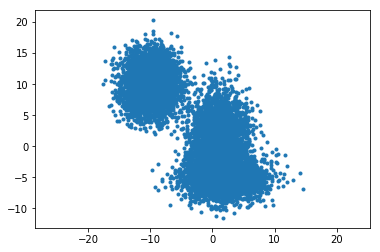

In [8]:
ploting(X_Data.T)

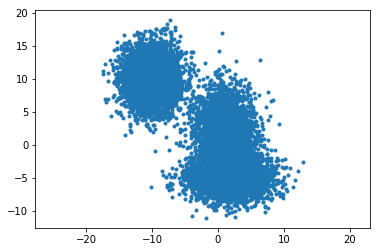

In [9]:
ploting(X_Data_hat.T)

In [10]:
print(X_Data.shape)
kmeans = KMeans(n_clusters=3, random_state=1).fit(X_Data.T)
lables = kmeans.labels_
print(np.array(kmeans.cluster_centers_).T)

(2, 10000)
[[-9.99834342  1.76391094  0.82325942]
 [10.0300581  -4.62867165  2.97667637]]


In [11]:
unique, counts = np.unique(lables, return_counts=True)
mixture_info = (((unique, counts)))

# print(np.array(np.asarray(mixture_info)))
print(counts)

[3881 4022 2097]


In [12]:
pi = np.array([0.4, 0.3, 0.3])

generators = [
    mult_gauss([-10, 10], [[5, 0], [0, 7]]),             
    mult_gauss([2, -5], [[10, 0], [0, 3]]), 
    mult_gauss([1, 1], [[5, 0], [0, 15]])]
N = 10
K = 3
tol = 0.000001
Data, mixture_info =  generate_data(generators, N, pi)

kmeans = KMeans(n_clusters=K, random_state=1).fit(Data.T)
lables = kmeans.labels_
unique, counts = np.unique(lables, return_counts=True)
pi = np.array(counts)/N
mu = np.array(kmeans.cluster_centers_).T
sigma =  np.array([np.eye(2)]*K) # initialize the covariances
print(Data.shape)
print(pi)
print(mu)
print(sigma)

(2, 10)
[0.3 0.5 0.2]
[[-8.65366801  0.34587275  1.35750512]
 [13.12542726 -4.38672234  6.90811082]]
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


In [13]:
A = pi[1]*mult_gauss.pdf(Data.T, mu[:,1], sigma[1,:,:])
# A = pi[1]*mult_gauss(mu[:,1], sigma[1,:,:]).pdf(Data.T)
# print(A)
# print(A.shape)
# 9.10421022e-110 8.57736183e-102

In [14]:
print(Data)
print( mu[:,0])
Aa = Data - np.reshape(mu[:,0], (2,1))
print( Aa.shape)

[[ -1.34120558  -7.38734487 -10.35224068   0.56183174   0.63412213
   -8.22141849   1.50123594   3.16312075   2.15317849  -2.22790948]
 [ -4.2924818   12.05500934  14.29203459   3.41238352   0.34518312
   13.02923786  -5.05487403  -8.21214558  10.40383812  -4.71929341]]
[-8.65366801 13.12542726]
(2, 10)


In [15]:
Bb = np.array([[1,2],[3,4],[5,6]])
print(Bb)

[[1 2]
 [3 4]
 [5 6]]


In [16]:
Br1 = np.reshape(Bb, (3,2,1))
print(Br1)
Br2 = np.reshape(Bb, (3,1,2))
print(Br2)

[[[1]
  [2]]

 [[3]
  [4]]

 [[5]
  [6]]]
[[[1 2]]

 [[3 4]]

 [[5 6]]]


In [17]:
Br12 = Br1*Br2
print(Br12)

[[[ 1  2]
  [ 2  4]]

 [[ 9 12]
  [12 16]]

 [[25 30]
  [30 36]]]


In [18]:
c = np.array([1, 2, 3])
c = np.reshape(c,(3,1,1))
Br12s = c*Br12
print(Br12s)

[[[  1   2]
  [  2   4]]

 [[ 18  24]
  [ 24  32]]

 [[ 75  90]
  [ 90 108]]]


In [19]:
print(Br12s.sum(0))

[[ 94 116]
 [116 144]]


In [20]:
l_new = 0
for i in range(N):
    dum = 0.0
    for j in range(K):
        dum += pi[j]*mult_gauss(mu[:,j], sigma[j,:,:]).pdf(X_Data[:,i])
    dum = np.log(dum)
    l_new += dum

In [21]:
dum = np.zeros((N,1))
results = [(pi[j]*mult_gauss.pdf(Data.T, mu[:,j], sigma[j,:,:]))
           for j in range(K)]
print(np.array(results))

[[1.54425403e-079 1.20760118e-002 5.71357279e-003 5.63959208e-041
  3.01642484e-056 4.32873041e-002 3.26612541e-096 3.10353441e-131
  5.13268242e-029 3.67937639e-080]
 [1.90901738e-002 1.63409618e-073 1.93452073e-102 4.81341538e-015
  1.04862295e-006 1.25415740e-083 3.26578626e-002 9.99112088e-007
  4.87789585e-050 2.74354750e-003]
 [4.78107596e-031 1.39548839e-024 7.73836761e-044 5.15005678e-005
  1.08705210e-011 2.76834854e-030 2.64100772e-033 1.41327414e-052
  5.15005678e-005 2.25853122e-034]]


In [22]:
results = [(i, j)
           for i in range(10)
           for j in range(i)]
print((pi[1]*mult_gauss.pdf(Data.T, mu[:,1], sigma[1,:,:])).shape)

(10,)


In [23]:
print(np.array(results))

[[1 0]
 [2 0]
 [2 1]
 [3 0]
 [3 1]
 [3 2]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [8 0]
 [8 1]
 [8 2]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]]
